# Cluster analysis

This is the first notebook for the first phase of APPG-LBA project of Geographic Data Science Lab, University of Liverpool.

The notebook uses `rapidsai/rapidsai:cuda11.0-runtime-ubuntu18.04-py3.8` Docker container with `clustergram` package on top.

The notebook harmonizes land cover categories across the years, combines values into a single DataFrame, generates clustergram and final clustering using `cuML`.

In [44]:
import geopandas as gpd
import pandas as pd
from clustergram import Clustergram
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from cuml import KMeans

Setting visual style for plots.

In [38]:
sns.set(context="paper", style='whitegrid')

Load all CLC on LSOA.

In [2]:
lsoa_clc2000 = gpd.read_parquet("../../data/clustering_phase_1/lsoa_clc2000.pq")
lsoa_clc2006 = gpd.read_parquet("../../data/clustering_phase_1/lsoa_clc2006.pq")
lsoa_clc2012 = gpd.read_parquet("../../data/clustering_phase_1/lsoa_clc2012.pq")
lsoa_clc2018 = gpd.read_parquet("../../data/clustering_phase_1/lsoa_clc2018.pq")

Check that shapes are corect.

In [3]:
lsoa_clc2000.shape

(34753, 36)

In [4]:
lsoa_clc2006.shape

(34753, 37)

In [5]:
lsoa_clc2012.shape

(34753, 37)

In [6]:
lsoa_clc2018.shape

(34753, 37)

Not all years contain the same classes (some are not detected at the specific year in England). Therefore, we have to harmonize data.

First we get the list of all existing classes and add a new column filled with 0 for every unique one which does not exist in each dataset.

In [7]:
columns = list(lsoa_clc2000.columns) + list(lsoa_clc2006.columns) + list(lsoa_clc2012.columns) + list(lsoa_clc2018.columns)

In [8]:
classes = np.unique(columns)[1:]

In [9]:
for c in classes:
    for year in [lsoa_clc2000, lsoa_clc2006, lsoa_clc2012, lsoa_clc2018]:
        if c not in year.columns:
            year[c] = 0

In [10]:
lsoa_clc2000.shape == lsoa_clc2006.shape == lsoa_clc2012.shape == lsoa_clc2018.shape

True

We can see that shapes of all DataFrames now match.

Now we merge all years together.

In [11]:
data = pd.concat([lsoa_clc2000, lsoa_clc2006, lsoa_clc2012, lsoa_clc2018], axis=0).drop(columns='geometry')

In [42]:
data.shape

(139012, 38)

We use merged DF as an input for clustergram to understand the optimal number of clusters.

In [13]:
cgram = Clustergram(k_range=range(1, 30), n_init=100, backend="cuML")
cgram.fit(data)

K=1 fitted in 10.353007555007935 seconds.
K=2 fitted in 7.000178098678589 seconds.
K=3 fitted in 9.171982049942017 seconds.
K=4 fitted in 9.522657632827759 seconds.
K=5 fitted in 11.491807222366333 seconds.
K=6 fitted in 13.427088022232056 seconds.
K=7 fitted in 13.950071573257446 seconds.
K=8 fitted in 15.111889123916626 seconds.
K=9 fitted in 15.629516363143921 seconds.
K=10 fitted in 17.290863275527954 seconds.
K=11 fitted in 17.923296213150024 seconds.
K=12 fitted in 20.383326768875122 seconds.
K=13 fitted in 21.10472011566162 seconds.
K=14 fitted in 23.177506685256958 seconds.
K=15 fitted in 24.85340118408203 seconds.
K=16 fitted in 24.790027379989624 seconds.
K=17 fitted in 29.01040005683899 seconds.
K=18 fitted in 28.789504289627075 seconds.
K=19 fitted in 33.06204390525818 seconds.
K=20 fitted in 35.06735920906067 seconds.
K=21 fitted in 35.23104810714722 seconds.
K=22 fitted in 37.10402297973633 seconds.
K=23 fitted in 39.0941219329834 seconds.
K=24 fitted in 40.20478272438049

We save clustergram object for potential further use.

In [33]:
import pickle

with open('clustergram_cuml.pickle','wb') as f:
    pickle.dump(cgram, f)

And plot its results.

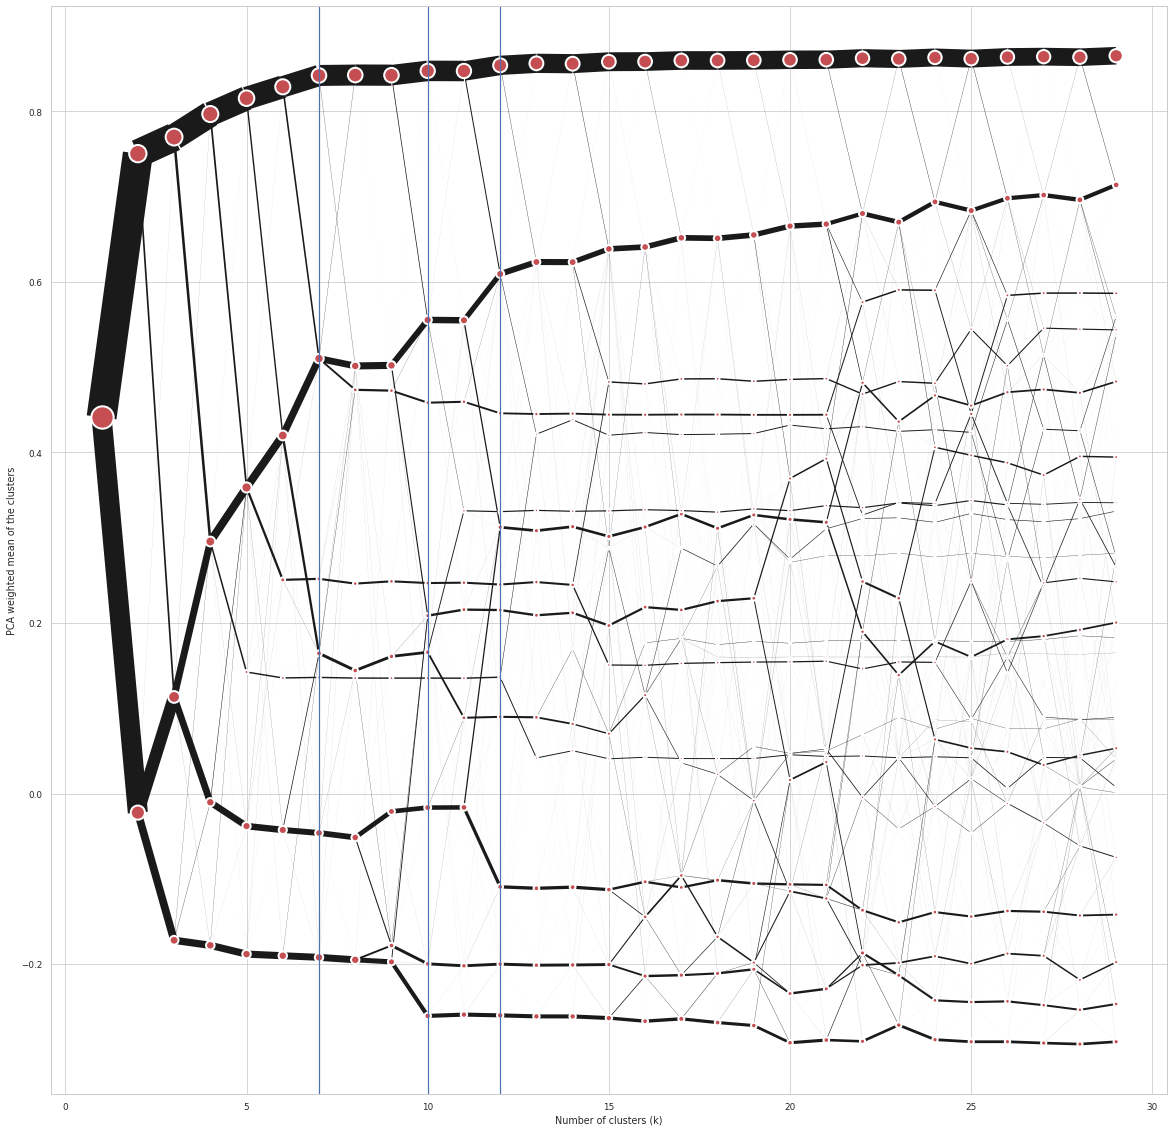

In [40]:
ax = cgram.plot(figsize=(20, 20))
plt.axvline(7)
plt.axvline(10)
plt.axvline(12)
plt.savefig("clustergram.svg")

Based on the branching, we can read that 7, 10 or 12 clusters are potential candidates.

We can run all three on 10 000 initialisations.

In [45]:
km = KMeans(n_clusters=10, random_state=123, n_init=10_000)
%time km.fit(data)

CPU times: user 15min 19s, sys: 13min 22s, total: 28min 42s
Wall time: 28min 37s


KMeans(handle=<cuml.raft.common.handle.Handle object at 0x7f90626bd770>, n_clusters=10, max_iter=300, tol=0.0001, verbose=4, random_state=123, init='scalable-k-means++', n_init=10000, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cupy')

In [55]:
labels10 = km.labels_.get()

In [56]:
km7 = KMeans(n_clusters=7, random_state=123, n_init=10_000)
%time km7.fit(data)

CPU times: user 12min 59s, sys: 11min 14s, total: 24min 14s
Wall time: 24min 10s


KMeans(handle=<cuml.raft.common.handle.Handle object at 0x7f906376cf50>, n_clusters=7, max_iter=300, tol=0.0001, verbose=4, random_state=123, init='scalable-k-means++', n_init=10000, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cupy')

In [57]:
labels7 = km7.labels_.get()

In [58]:
km12 = KMeans(n_clusters=12, random_state=123, n_init=10_000)
%time km12.fit(data)

CPU times: user 17min 52s, sys: 15min 31s, total: 33min 24s
Wall time: 33min 14s


KMeans(handle=<cuml.raft.common.handle.Handle object at 0x7f906376c550>, n_clusters=12, max_iter=300, tol=0.0001, verbose=4, random_state=123, init='scalable-k-means++', n_init=10000, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cupy')

In [59]:
labels12 = km12.labels_.get()

Finally, we save all labels attached to LSOA data.

In [61]:
lsoa = gpd.read_file("../../data/lsoa")

In [68]:
n = lsoa.shape[0]

In [69]:
lsoa['clusters_7_2000'] = labels7[:n]
lsoa['clusters_7_2006'] = labels7[n:2*n]
lsoa['clusters_7_2012'] = labels7[2*n:3*n]
lsoa['clusters_7_2018'] = labels7[-n:]

lsoa['clusters_10_2000'] = labels10[:n]
lsoa['clusters_10_2006'] = labels10[n:2*n]
lsoa['clusters_10_2012'] = labels10[2*n:3*n]
lsoa['clusters_10_2018'] = labels10[-n:]

lsoa['clusters_12_2000'] = labels12[:n]
lsoa['clusters_12_2006'] = labels12[n:2*n]
lsoa['clusters_12_2012'] = labels12[2*n:3*n]
lsoa['clusters_12_2018'] = labels12[-n:]

In [71]:
lsoa.to_file("../../data/lsoa_clustered.gpkg", driver="GPKG")